## Introduction

In this notebook, we try to find for our customer the perfect place to rent a house in Hamburg that is close to their new job location (max. 7 km distance).

Our aim is to cluster the relevant quarters of Hamburg, find a cluster which stands for family friendliness with parks and playgrounds and select the quarter which has the lowest rental prices in the family-friendly cluster.

We use the k-means algorithm for clustering and the Folium library for visualization.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Create the Data Set</a>

2.  <a href="#item2">Explore the Quarters of Hamburg</a>

3.  <a href="#item3">Cluster the Quarters of Hamburg</a>

    </font>
    </div>



Before we start, let's download the dependencies.

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment if not installed yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment if not installed yet
import folium # map rendering library
 
#!pip install tabula-py #uncomment if not installed yet
import tabula

from sklearn.metrics import silhouette_score

print('Libraries imported.')

Libraries imported.


## 1. Create the Dataset

At first, we need to have the quarters of Hamburg. We scrape the data from Wikipedia.

In [2]:
df = pd.read_html("https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs")

In [3]:
df1 = df[1]
df1.head()

,Stadtteil,Ortsteile,Bezirk,Fläche (km²),Einwohner,Bevölkerungs­dichte (Einwohner/km²),Koordinaten,Karte
0,Hamburg-Altstadt,101–102,Hamburg-Mitte,24,2350.000,979,"53° 33′ 0″ N, 10° 0′ 0″ O",NaN
1,HafenCity,103–104,Hamburg-Mitte,22,4925.000,2239,"53° 32′ 28″ N, 10° 0′ 1″ O",NaN
2,Neustadt,105–108,Hamburg-Mitte,23,12.762,5549,"53° 33′ 7″ N, 9° 59′ 8″ O",NaN
3,St. Pauli,109–112,Hamburg-Mitte,25,22.097,8839,"53° 33′ 25″ N, 9° 57′ 50″ O",NaN
4,St. Georg,113–114,Hamburg-Mitte,24,11.358,4733,"53° 33′ 18″ N, 10° 0′ 44″ O",NaN


The dataframe looks good. We drop the data we don't need.

In [4]:
df1 = df1[["Stadtteil", "Bezirk", "Bevölkerungs­dichte (Einwohner/km²)"]]

In [5]:
df1.head()

,Stadtteil,Bezirk,Bevölkerungs­dichte (Einwohner/km²)
0,Hamburg-Altstadt,Hamburg-Mitte,979
1,HafenCity,Hamburg-Mitte,2239
2,Neustadt,Hamburg-Mitte,5549
3,St. Pauli,Hamburg-Mitte,8839
4,St. Georg,Hamburg-Mitte,4733


Let's make it understandable for English readers ...

In [6]:
df1.rename(columns={"Stadtteil":"Quarter", "Bezirk": "Borough", "Bevölkerungs­dichte (Einwohner/km²)":"Population density per km²"}, inplace=True)
df1.head()

,Quarter,Borough,Population density per km²
0,Hamburg-Altstadt,Hamburg-Mitte,979
1,HafenCity,Hamburg-Mitte,2239
2,Neustadt,Hamburg-Mitte,5549
3,St. Pauli,Hamburg-Mitte,8839
4,St. Georg,Hamburg-Mitte,4733


How many quarter does Hamburg have?

In [7]:
df1.shape[0]

104

104 Boroughs. And how do distribute across the boroughs of Hamburg?

In [8]:
df1["Borough"].value_counts(normalize=True)

Hamburg-Mitte    0.182692
Wandsbek         0.173077
Harburg          0.163462
Bergedorf        0.134615
Altona           0.134615
Hamburg-Nord     0.125000
Eimsbüttel       0.086538
Name: Borough, dtype: float64

Now, we use the GeoPy service to get the latitude and longitude data. Let the magic begin ...

In [9]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")

latitude = []
longitude = []

for i, value in enumerate(df1["Quarter"]):
    quarter = value
    borough = df1.iloc[i]["Borough"]
    country ="Germany"
    loc = geolocator.geocode(quarter+ "," + borough+ "," + country)
    latitude.append(loc.latitude)
    longitude.append(loc.longitude)
df1["Latitude"] = latitude
df1["Longitude"] = longitude
df1

,Quarter,Borough,Population density per km²,Latitude,Longitude
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550468,9.994640
1,HafenCity,Hamburg-Mitte,2239,53.542913,9.995835
2,Neustadt,Hamburg-Mitte,5549,53.549881,9.979048
3,St. Pauli,Hamburg-Mitte,8839,53.553935,9.959432
4,St. Georg,Hamburg-Mitte,4733,53.557149,10.014256
5,Hammerbrook,Hamburg-Mitte,1540,53.546815,10.026559
6,Borgfelde,Hamburg-Mitte,10429,53.555029,10.033300
7,Hamm,Hamburg-Mitte,9583,53.553443,10.051294
8,Horn,Hamburg-Mitte,6504,53.554062,10.088918
9,Billstedt,Hamburg-Mitte,4142,53.548899,10.122625


This looks great. The location data for the quarter "Neuwerk" seems strange and leads to the asumption that is is not located in Hamburg. A quick search on Wikipedia shows why. Neuwerk is an enclave of Hamburg and is approx. 100 km apart from the city borders. We don't need to drop the entry now, because we will make further selections which will lead the dropout anyway.

Next, let's locate our client's job location. The idea is to select only quarters which are approx. 7 km away from the latter location. We assign the address of the job location to the variable wp_location and retrieve the location data by the GeoPy Geolocator.

In [10]:
wp_location = ["Sylvesterallee 7 22525 Bahrenfeld Altona Hamburg"]

wp_address = []

loc = geolocator.geocode(["Sylvesterallee 7 22525 Bahrenfeld Altona Hamburg"])
wp_address.append(loc.latitude)
wp_address.append(loc.longitude)

Now, that we know where the job location is, we only want to select quarters that are within a 7 km radius from their job location.

In [11]:
from geopy import distance

in_out = []

center_point = [{'lat': wp_address[0], 'lng': wp_address[1]}]

for i in df1.index:
    test_point = [{'lat': df1.iloc[i]["Latitude"], 'lng': df1.iloc[i]["Longitude"]}]
    radius = 7# in kilometer
    center_point_tuple = tuple(center_point[0].values()) # (-7.7940023, 110.3656535)
    test_point_tuple = tuple(test_point[0].values()) # (-7.79457, 110.36563)
    dis = distance.distance(center_point_tuple, test_point_tuple).km
    if dis <= radius:
        in_out.append(1)
    else:
        in_out.append(0)
df1["Inside the 7 km radius"] = in_out    

In [12]:
df1.head()

,Quarter,Borough,Population density per km²,Latitude,Longitude,Inside the 7 km radius
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550468,9.994640,0
1,HafenCity,Hamburg-Mitte,2239,53.542913,9.995835,0
2,Neustadt,Hamburg-Mitte,5549,53.549881,9.979048,1
3,St. Pauli,Hamburg-Mitte,8839,53.553935,9.959432,1
4,St. Georg,Hamburg-Mitte,4733,53.557149,10.014256,0


OK, how many quarters remain? Let's see.

In [13]:
df1["Inside the 7 km radius"].value_counts(normalize=True)

0    0.730769
1    0.269231
Name: Inside the 7 km radius, dtype: float64

Approimately 27% of the quarters are still in. We drop the rest.

In [14]:
df2 = df1[df1["Inside the 7 km radius"] == 1].reset_index(drop=True).drop(columns=["Inside the 7 km radius"])

To which boroughs do the remaining quarters belong?

In [15]:
df2.Borough.value_counts()

Altona           12
Eimsbüttel        9
Hamburg-Mitte     4
Hamburg-Nord      3
Name: Borough, dtype: int64

That makes seens since the job location is in Hamburg Altona.

Let's take a look at the data set. 

In [16]:
df2

,Quarter,Borough,Population density per km²,Latitude,Longitude
0,Neustadt,Hamburg-Mitte,5549,53.549881,9.979048
1,St. Pauli,Hamburg-Mitte,8839,53.553935,9.959432
2,Steinwerder,Hamburg-Mitte,4,53.539324,9.961541
3,Finkenwerder,Hamburg-Mitte,597,53.530882,9.858523
4,Altona-Altstadt,Altona,10418,53.549660,9.945352
5,Sternschanze,Altona,16184,53.561768,9.963282
6,Altona-Nord,Altona,11153,53.561400,9.944720
7,Ottensen,Altona,12709,53.555066,9.919819
8,Bahrenfeld,Altona,2849,53.569070,9.905583
9,Groß Flottbek,Altona,4630,53.565586,9.879233


Good, that we kept the column "Population density per km²". Because it's noticeable that the Population density for Steinwerder completely gets out of the line. A research shows that it is not allowed to live there. That means we drop the entry. And we also drop the column "Population density per km²" from here on. 

One last thing to get all the data ready. We need to scrape the rental princes from the Internet, modify and merge them with df2. Here, we will use the average rental prices for Hamburg from 2017, assuming that the changes that probably took place are linear which is OK for our analysis, because we use the information as ordinal data.

In [17]:
df2 = df2[["Quarter", "Borough", "Latitude", "Longitude"]].drop([2]).reset_index(drop=True)

In [18]:
rental_prices = pd.read_html("https://mietspiegeltabelle.de/mietspiegel-hamburg/")
rental_prices = rental_prices[0]
rental_prices.head()

,Stadtteil,Miete pro m2
0,Allermöhe,"8,70 Euro"
1,Alsterdorf,"10,72 Euro"
2,Altengamme,"8,00 Euro"
3,Altenwerder,"9,08 Euro"
4,Altona-Altstadt,"10,60 Euro"


The data set needs some modifications.

In [19]:
rental_prices.rename(columns={"Stadtteil":"Quarter", "Miete pro m2": "Price per m^2 in EURO"}, inplace=True)

for i in rental_prices.index:
    rental_prices["Price per m^2 in EURO"][i] = rental_prices["Price per m^2 in EURO"][i].split()[0]

rental_prices.head()

,Quarter,Price per m^2 in EURO
0,Allermöhe,"8,70"
1,Alsterdorf,"10,72"
2,Altengamme,"8,00"
3,Altenwerder,"9,08"
4,Altona-Altstadt,"10,60"


Let's merge the data sets to become df_dinal.

In [20]:
df_final = df2.merge(rental_prices, on="Quarter", how = 'inner')
df_final.head()

,Quarter,Borough,Latitude,Longitude,Price per m^2 in EURO
0,Neustadt,Hamburg-Mitte,53.549881,9.979048,"10,69"
1,Finkenwerder,Hamburg-Mitte,53.530882,9.858523,"7,85"
2,Altona-Altstadt,Altona,53.549660,9.945352,"10,60"
3,Sternschanze,Altona,53.561768,9.963282,"11,73"
4,Altona-Nord,Altona,53.561400,9.944720,"10,61"


Now, we are ready :).

--------------

## 2. Explore the Quarters of Hamburg

At first, we want to get the coordinates of Hamburg.

In [21]:
address = 'Hamburg'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hamburg are 53.550341, 10.000654.


Then, we create a map of Hamburg with the selected quarters superimposed on top.

In [22]:
# create map of Toronto using latitude and longitude values
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, quarter in zip(df_final['Latitude'], df_final['Longitude'], df_final['Quarter']):
    label = '{}, {}'.format(df_final, quarter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  
    
map_hamburg

In [1]:
# @hidden_cell

We create a function to get the venue categories for all quarters ...

In [24]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quarter', 
                  'Quarter Latitude', 
                  'Quarter Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

... and run it.

In [25]:
hamburg_venues = getNearbyVenues(names=df_final["Quarter"],
                                   latitudes=df_final["Latitude"],
                                   longitudes=df_final["Longitude"]
                                )

Neustadt
Finkenwerder
Altona-Altstadt
Sternschanze
Altona-Nord
Ottensen
Bahrenfeld
Groß Flottbek
Othmarschen
Lurup
Osdorf
Nienstedten
Iserbrook
Sülldorf
Eimsbüttel
Rotherbaum
Harvestehude
Hoheluft-West
Lokstedt
Niendorf
Schnelsen
Eidelstedt
Stellingen
Hoheluft-Ost
Eppendorf
Groß Borstel


Now we check the size of the new dataframe.

In [26]:
print(hamburg_venues.shape)

(2528, 7)


Let's check how many venues were returned for each neighborhood.

In [27]:
hamburg_venues.groupby("Quarter").count()

,Quarter Latitude,Quarter Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Quarter,,,,,,
Altona-Altstadt,100,100,100,100,100,100
Altona-Nord,100,100,100,100,100,100
Bahrenfeld,100,100,100,100,100,100
Eidelstedt,100,100,100,100,100,100
Eimsbüttel,100,100,100,100,100,100
Eppendorf,100,100,100,100,100,100
Finkenwerder,100,100,100,100,100,100
Groß Borstel,100,100,100,100,100,100
Groß Flottbek,100,100,100,100,100,100


In [28]:
print('There are {} uniques categories.'.format(len(hamburg_venues["Venue Category"].unique())))

There are 154 uniques categories.


In [29]:
hamburg_venues.head()

,Quarter,Quarter Latitude,Quarter Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Neustadt,53.549881,9.979048,Public Coffee Roasters,53.551372,9.982597,Coffee Shop
1,Neustadt,53.549881,9.979048,Milch,53.545892,9.974792,Café
2,Neustadt,53.549881,9.979048,Restaurant Buon Giorno,53.549316,9.983093,Italian Restaurant
3,Neustadt,53.549881,9.979048,Laeiszhalle,53.555916,9.980779,Concert Hall
4,Neustadt,53.549881,9.979048,Landungsbrücken,53.545404,9.970021,Pier


Analyze Each Neighborhood

In [30]:
# one hot encoding
hamburg_onehot = pd.get_dummies(hamburg_venues[['Venue Category']], prefix="", prefix_sep="")

# add quarter column back to dataframe
hamburg_onehot['Quarter'] = hamburg_venues['Quarter'] 

# move quarter column to the first column
fixed_columns = [hamburg_onehot.columns[-1]] + list(hamburg_onehot.columns[:-1])
hamnburg_onehot = hamburg_onehot[fixed_columns]

hamburg_onehot.head()

,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Stop,Café,Campground,Canal,Candy Store,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cooking School,Deli / Bodega,Dessert Shop,Doner Restaurant,Drugstore,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Hobby Shop,Hockey Rink,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Lake,Lebanese Restaurant,Lighthouse,Liquor Store,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Mobile Phone Shop,Movie Theater,Nature Preserve,Neighborhood,Nightclub,Organic Grocery,Other Nightlife,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spanish Restaurant,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Taverna,Tea Room,Theater,Track,Trail,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Zoo,Zoo Exhibit,Quarter
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neustadt
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neustadt
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neustadt
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neustadt
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neustadt


Next, let's group rows by quarters and by taking the mean of the frequency of occurrence of each category.

In [31]:
hamburg_grouped = hamburg_onehot.groupby('Quarter').mean().reset_index()
hamburg_grouped.head()

,Quarter,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Stop,Café,Campground,Canal,Candy Store,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cooking School,Deli / Bodega,Dessert Shop,Doner Restaurant,Drugstore,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Hobby Shop,Hockey Rink,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Lake,Lebanese Restaurant,Lighthouse,Liquor Store,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Mobile Phone Shop,Movie Theater,Nature Preserve,Neighborhood,Nightclub,Organic Grocery,Other Nightlife,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spanish Restaurant,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Taverna,Tea Room,Theater,Track,Trail,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Zoo,Zoo Exhibit
0,Altona-Altstadt,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.02,0.0,0.05,0.0,0.01,0.0,0.01,0.02,0.0,0.0,0.02,0.0,0.02,0.0,0.01,0.00,0.00,0.00,0.01,0.01,0.0,0.07,0.0,0.00,0.01,0.0,0.00,0.01,0.0,0.01,0.01,0.06,0.0,0.02,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.01,0.01,0.0,0.00,0.02,0.0,0.01,0.0,0.00,0.0,0.02,0.00,0.00,0.01,0.0,0.02,0.0,0.0,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.0,0.0,0.00,0.01,0.03,0.03,0.01,0.0,0.0,0.00,0.01,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.02,0.01,0.00,0.00,0.06,0.00,0.0,0.01,0.01,0.04,0.0,0.00,0.02,0.00,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.02,0.04,0.01,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.00,0.0,0.00,0.00,0.02,0.01,0.00,0.01,0.0,0.0,0.00,0.00,0.00,0.01,0.0,0.0,0.0,0.00,0.02,0.00,0.00
1,Altona-Nord,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.02,0.0,0.08,0.0,0.01,0.0,0.00,0.00,0.0,0.0,0.02,0.0,0.02,0.0,0.01,0.00,0.01,0.00,0.01,0.01,0.0,0.11,0.0,0.01,0.01,0.0,0.00,0.01,0.0,0.00,0.01,0.06,0.0,0.01,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.02,0.00,0.0,0.00,0.02,0.0,0.01,0.0,0.00,0.0,0.02,0.00,0.00,0.01,0.0,0.01,0.0,0.0,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0.01,0.02,0.03,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.02,0.01,0.00,0.00,0.06,0.00,0.0,0.01,0.01,0.04,0.0,0.00,0.01,0.00,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.01,0.04,0.01,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.00,0.0,0.00,0.00,0.02,0.01,0.00,0.01,0.0,0.0,0.00,0.01,0.00,0.01,0.0,0.0,0.0,0.00,0.02,0.00,0.00
2,Bahrenfeld,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.01,0.0,0.10,0.0,0.01,0.0,0.02,0.02,0.0,0.0,0.01,0.0,0.02,0.0,0.01,0.01,0.00,0.00,0.01,0.00,0.0,0.11,0.0,0.00,0.01,0.0,0.00,0.01,0.0,0.00,0.01,0.04,0.0,0.00,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.02,0.03,0.0,0.00,0.01,0.0,0.00,0.0,0.01,0.0,0.02,0.00,0.01,0.01,0.0,0.02,0.0,0.0,0.00,0.01,0.01,0.02,0.00,0.02,0.00,0.0,0.0,0.00,0.01,0.02,0.03,0.01,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01

In [32]:
hamburg_grouped.shape

(26, 155)

Let's print each quarter along with the top 5 most common venues.

In [33]:
num_top_venues = 5

for quart in hamburg_grouped['Quarter']:
    print("----"+quart+"----")
    temp = hamburg_grouped[hamburg_grouped['Quarter'] == quart].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Altona-Altstadt----
         venue  freq
0         Café  0.07
1         Park  0.06
2  Coffee Shop  0.06
3       Bakery  0.05
4  Pizza Place  0.04


----Altona-Nord----
                venue  freq
0                Café  0.11
1              Bakery  0.08
2                Park  0.06
3         Coffee Shop  0.06
4  Seafood Restaurant  0.04


----Bahrenfeld----
            venue  freq
0            Café  0.11
1          Bakery  0.10
2            Park  0.09
3     Coffee Shop  0.04
4  Farmers Market  0.03


----Eidelstedt----
         venue  freq
0         Café  0.10
1  Supermarket  0.07
2       Bakery  0.05
3  Zoo Exhibit  0.04
4         Park  0.04


----Eimsbüttel----
         venue  freq
0       Bakery  0.10
1         Café  0.09
2  Coffee Shop  0.07
3         Park  0.06
4     Wine Bar  0.04


----Eppendorf----
         venue  freq
0         Café  0.11
1         Park  0.09
2       Bakery  0.07
3  Coffee Shop  0.04
4     Wine Bar  0.03


----Finkenwerder----
                venue  freq
0   

Now, we turn the data into a pandas dataframe.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe showing the 15 most common venues in the respective quarter.

In [35]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quarter']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quarters_venues_sorted = pd.DataFrame(columns=columns)
quarters_venues_sorted['Quarter'] = hamburg_grouped['Quarter']

for ind in np.arange(hamburg_grouped.shape[0]):
    quarters_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped.iloc[ind, :], num_top_venues)

quarters_venues_sorted

,Quarter,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Altona-Altstadt,Café,Park,Coffee Shop,Bakery,Seafood Restaurant,Pizza Place,Ice Cream Shop,Hotel,Nightclub,Scenic Lookout,Bistro,Beer Store,Concert Hall,Supermarket,Beach Bar
1,Altona-Nord,Café,Bakery,Coffee Shop,Park,Seafood Restaurant,Pizza Place,Ice Cream Shop,Nightclub,Bistro,Supermarket,Falafel Restaurant,Beer Store,Austrian Restaurant,Asian Restaurant,Hotel
2,Bahrenfeld,Café,Bakery,Park,Coffee Shop,Farmers Market,Ice Cream Shop,Seafood Restaurant,Supermarket,Pizza Place,German Restaurant,Falafel Restaurant,Wine Bar,Bistro,Beach Bar,French Restaurant
3,Eidelstedt,Café,Supermarket,Bakery,Zoo Exhibit,Park,Ice Cream Shop,German Restaurant,Italian Restaurant,Gym / Fitness Center,Wine Bar,Hotel,Farmers Market,Climbing Gym,Forest,Taverna
4,Eimsbüttel,Bakery,Café,Coffee Shop,Park,Pizza Place,Wine Bar,Ice Cream Shop,French Restaurant,Plaza,Hotel,Fish Market,Farmers Market,Cocktail Bar,Falafel Restaurant,Asian Restaurant
5,Eppendorf,Café,Park,Bakery,Coffee Shop,Wine Bar,Farmers Market,Supermarket,Ice Cream Shop,Tapas Restaurant,Bistro,Cocktail Bar,Italian Restaurant,Restaurant,Plaza,Beer Store
6,Finkenwerder,Café,Ice Cream Shop,Seafood Restaurant,Restaurant,Park,Hotel,Supermarket,German Restaurant,Beach,Art Museum,Tea Room,Harbor / Marina,Italian Restaurant,French Restaurant,Bakery
7,Groß Borstel,Café,Park,Supermarket,Bakery,Coffee Shop,Italian Restaurant,Ice Cream Shop,Wine Bar,Hotel,Bistro,Tapas Restaurant,Plaza,Drugstore,Hawaiian Restaurant,Farmers Market
8,Groß Flottbek,Park,Bakery,Café,Seafood Restaurant,Ice Cream Shop,Supermarket,Falafel Restaurant,Restaurant,Harbor / Marina,Shopping Mall,Beach Bar,Beach,Farmers Market,Grocery Store,Bar
9,Harvestehude,Café,Bakery,Coffee Shop,Park,Plaza,Ice Cream Shop,Restaurant,Wine Bar,Farmers Market,Seafood Restaurant,Beer Store,Hotel,German Restaurant,Italian Restaurant,Supermarket


Now we are ready to use some machine learning.

--------------

## 3. Cluster the Quarters in Hamburg

In this chapter, we want to cluster the quarters and use the well-known and easy-to-use k-means algorithm. For this algorithm, we need to determine how many clusters we want. However, this is not useful method. We could test with different k's (meaning the number of cluster) but we use the silhouette scores which tells us which k leads to the best results.

In [36]:
hamburg_grouped_clustering = hamburg_grouped.drop('Quarter', 1)

kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(hamburg_grouped_clustering)
                for k in range(1, 10)]

silhouette_scores = [silhouette_score(hamburg_grouped_clustering, model.labels_)
                     for model in kmeans_per_k[1:]]

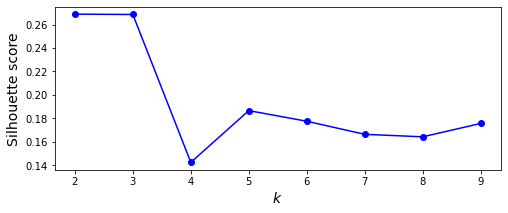

In [37]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [38]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hamburg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 2, 1, 1, 0, 1, 1, 1], dtype=int32)

We see, that only k=2 or k=3 are reasonable choices. Although k=2 has a slightly higher score, we will go with k=3 and see if it makes sense. If not, we will return and take k=2.

Now, let's run the k-means algorithm.

We merge the cluster labels data set with "quarters_venues_sorted". We get the data set "hamburg_merged".

In [39]:
# add clustering labels
quarters_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hamburg_merged = df_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hamburg_merged = hamburg_merged.join(quarters_venues_sorted.set_index('Quarter'), on='Quarter')

hamburg_merged

,Quarter,Borough,Latitude,Longitude,Price per m^2 in EURO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Neustadt,Hamburg-Mitte,53.549881,9.979048,"10,69",1,Park,Café,Coffee Shop,Bakery,Seafood Restaurant,Plaza,Pizza Place,Ice Cream Shop,Pub,Nightclub,Beer Store,Scenic Lookout,Cocktail Bar,Supermarket,Concert Hall
1,Finkenwerder,Hamburg-Mitte,53.530882,9.858523,"7,85",0,Café,Ice Cream Shop,Seafood Restaurant,Restaurant,Park,Hotel,Supermarket,German Restaurant,Beach,Art Museum,Tea Room,Harbor / Marina,Italian Restaurant,French Restaurant,Bakery
2,Altona-Altstadt,Altona,53.549660,9.945352,"10,60",1,Café,Park,Coffee Shop,Bakery,Seafood Restaurant,Pizza Place,Ice Cream Shop,Hotel,Nightclub,Scenic Lookout,Bistro,Beer Store,Concert Hall,Supermarket,Beach Bar
3,Sternschanze,Altona,53.561768,9.963282,"11,73",1,Café,Bakery,Coffee Shop,Plaza,Seafood Restaurant,Pizza Place,Park,Wine Bar,Falafel Restaurant,Austrian Restaurant,Scenic Lookout,Beer Store,Ice Cream Shop,Hotel,Concert Hall
4,Altona-Nord,Altona,53.561400,9.944720,"10,61",1,Café,Bakery,Coffee Shop,Park,Seafood Restaurant,Pizza Place,Ice Cream Shop,Nightclub,Bistro,Supermarket,Falafel Restaurant,Beer Store,Austrian Restaurant,Asian Restaurant,Hotel
5,Ottensen,Altona,53.555066,9.919819,"11,60",1,Café,Park,Bakery,Coffee Shop,Pizza Place,Ice Cream Shop,Seafood Restaurant,Supermarket,Beach Bar,Nightclub,Beach,Farmers Market,Fish Market,Hotel,Bistro
6,Bahrenfeld,Altona,53.569070,9.905583,"10,09",1,Café,Bakery,Park,Coffee Shop,Farmers Market,Ice Cream Shop,Seafood Restaurant,Supermarket,Pizza Place,German Restaurant,Falafel Restaurant,Wine Bar,Bistro,Beach Bar,French Restaurant
7,Groß Flottbek,Altona,53.565586,9.879233,"11,38",1,Park,Bakery,Café,Seafood Restaurant,Ice Cream Shop,Supermarket,Falafel Restaurant,Restaurant,Harbor / Marina,Shopping Mall,Beach Bar,Beach,Farmers Market,Grocery Store,Bar
8,Othmarschen,Altona,53.555063,9.887860,"11,81",1,Park,Bakery,Café,Ice Cream Shop,Seafood Restaurant,Farmers Market,Wine Bar,Pizza Place,Supermarket,Bistro,Beach Bar,Shopping Mall,Bar,Beach,Nightclub
9,Lurup,Altona,53.592952,9.874564,"8,40",2,Supermarket,Bakery,Zoo Exhibit,Gym / Fitness Center,Drugstore,Café,Hotel,Park,Clothing Store,Shopping Mall,German Restaurant,Taverna,Furniture / Home Store,Hardware Store,Steakhouse


Finally, let's visualize the resulting clusters.

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamburg_merged['Latitude'], hamburg_merged['Longitude'], hamburg_merged['Quarter'], hamburg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

folium.Marker([wp_address[0], wp_address[1]], icon=folium.Icon(color='cadetblue', icon='building', prefix='fa')).add_to(map_clusters)
folium.Circle(radius=1000, location=[wp_address[0], wp_address[1]], popup="Job Location", color="#cadetblue", fill=True, fill_color="#cadetblue").add_to(map_clusters)

map_clusters

That looks awesome. We have three clusters where you also can observe geographical clusters.

Let's have a closer look at the 3 clusters.

#### Cluster 1: Red dots on the map.

In [41]:
hamburg_merged.loc[hamburg_merged['Cluster Labels'] == 0, hamburg_merged.columns[[0,4] + list(range(5, hamburg_merged.shape[1]))]]

,Quarter,Price per m^2 in EURO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,Finkenwerder,"7,85",0,Café,Ice Cream Shop,Seafood Restaurant,Restaurant,Park,Hotel,Supermarket,German Restaurant,Beach,Art Museum,Tea Room,Harbor / Marina,Italian Restaurant,French Restaurant,Bakery
10,Osdorf,"9,82",0,Park,Bakery,Café,Supermarket,Seafood Restaurant,Ice Cream Shop,Beach,Hotel,German Restaurant,Coffee Shop,Shopping Mall,Restaurant,Beach Bar,Clothing Store,Harbor / Marina
11,Nienstedten,"11,93",0,Supermarket,Café,Seafood Restaurant,German Restaurant,Park,Ice Cream Shop,Beach,Bakery,Restaurant,Pool,Shopping Mall,Beach Bar,Garden,Tea Room,Harbor / Marina
12,Iserbrook,"9,34",0,Supermarket,Restaurant,Café,Seafood Restaurant,Hotel,Ice Cream Shop,Beach,Clothing Store,Bakery,Shopping Mall,Golf Course,Italian Restaurant,Drugstore,Steakhouse,Garden
13,Sülldorf,"9,62",0,Supermarket,Café,Ice Cream Shop,Drugstore,Seafood Restaurant,Clothing Store,German Restaurant,Restaurant,Shopping Mall,Beach,Hotel,Liquor Store,Coffee Shop,Bakery,Pool


Cluster 1 this cluster is definitely not what we were looking for. Maybe cluster 2 fits better into our expecations ...

#### Cluster 2: Blue dots on the map.

In [42]:
hamburg_merged.loc[hamburg_merged['Cluster Labels'] == 1, hamburg_merged.columns[[0,4] + list(range(5, hamburg_merged.shape[1]))]]

,Quarter,Price per m^2 in EURO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Neustadt,"10,69",1,Park,Café,Coffee Shop,Bakery,Seafood Restaurant,Plaza,Pizza Place,Ice Cream Shop,Pub,Nightclub,Beer Store,Scenic Lookout,Cocktail Bar,Supermarket,Concert Hall
2,Altona-Altstadt,"10,60",1,Café,Park,Coffee Shop,Bakery,Seafood Restaurant,Pizza Place,Ice Cream Shop,Hotel,Nightclub,Scenic Lookout,Bistro,Beer Store,Concert Hall,Supermarket,Beach Bar
3,Sternschanze,"11,73",1,Café,Bakery,Coffee Shop,Plaza,Seafood Restaurant,Pizza Place,Park,Wine Bar,Falafel Restaurant,Austrian Restaurant,Scenic Lookout,Beer Store,Ice Cream Shop,Hotel,Concert Hall
4,Altona-Nord,"10,61",1,Café,Bakery,Coffee Shop,Park,Seafood Restaurant,Pizza Place,Ice Cream Shop,Nightclub,Bistro,Supermarket,Falafel Restaurant,Beer Store,Austrian Restaurant,Asian Restaurant,Hotel
5,Ottensen,"11,60",1,Café,Park,Bakery,Coffee Shop,Pizza Place,Ice Cream Shop,Seafood Restaurant,Supermarket,Beach Bar,Nightclub,Beach,Farmers Market,Fish Market,Hotel,Bistro
6,Bahrenfeld,"10,09",1,Café,Bakery,Park,Coffee Shop,Farmers Market,Ice Cream Shop,Seafood Restaurant,Supermarket,Pizza Place,German Restaurant,Falafel Restaurant,Wine Bar,Bistro,Beach Bar,French Restaurant
7,Groß Flottbek,"11,38",1,Park,Bakery,Café,Seafood Restaurant,Ice Cream Shop,Supermarket,Falafel Restaurant,Restaurant,Harbor / Marina,Shopping Mall,Beach Bar,Beach,Farmers Market,Grocery Store,Bar
8,Othmarschen,"11,81",1,Park,Bakery,Café,Ice Cream Shop,Seafood Restaurant,Farmers Market,Wine Bar,Pizza Place,Supermarket,Bistro,Beach Bar,Shopping Mall,Bar,Beach,Nightclub
14,Eimsbüttel,"11,36",1,Bakery,Café,Coffee Shop,Park,Pizza Place,Wine Bar,Ice Cream Shop,French Restaurant,Plaza,Hotel,Fish Market,Farmers Market,Cocktail Bar,Falafel Restaurant,Asian Restaurant
15,Rotherbaum,"12,41",1,Coffee Shop,Café,Ice Cream Shop,Wine Bar,Restaurant,Park,Cocktail Bar,Plaza,Hotel,Farmers Market,Bakery,Italian Restaurant,Theater,Beer Store,Trail


Bingo! That's our cluster! We almost have in every quarter a park either as the most common venue or as the 2nd most common. Playgrounds seem to be underrepresented across all clusters. Here, we still have a clear tendency towards our customer's expectations and wishes. The last task was to determine the quarter with the lowest rental prices. A quick look at table reveals: Groß Borstel is the way to go!

#### Cluster 3: Green dots on the map.

In [43]:
hamburg_merged.loc[hamburg_merged['Cluster Labels'] == 2, hamburg_merged.columns[[0,4] + list(range(5, hamburg_merged.shape[1]))]]

,Quarter,Price per m^2 in EURO,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
9,Lurup,"8,40",2,Supermarket,Bakery,Zoo Exhibit,Gym / Fitness Center,Drugstore,Café,Hotel,Park,Clothing Store,Shopping Mall,German Restaurant,Taverna,Furniture / Home Store,Hardware Store,Steakhouse
19,Niendorf,"9,55",2,Supermarket,Hotel,Bakery,Café,Greek Restaurant,Park,Zoo Exhibit,Airport Service,Ice Cream Shop,Pool,Italian Restaurant,Gym / Fitness Center,Drugstore,Furniture / Home Store,Airport Lounge
20,Schnelsen,"8,88",2,Zoo Exhibit,Supermarket,Ice Cream Shop,Furniture / Home Store,Indoor Play Area,Bakery,German Restaurant,Italian Restaurant,Hotel,Greek Restaurant,Mexican Restaurant,Chinese Restaurant,Climbing Gym,Playground,Grocery Store
21,Eidelstedt,"8,92",2,Café,Supermarket,Bakery,Zoo Exhibit,Park,Ice Cream Shop,German Restaurant,Italian Restaurant,Gym / Fitness Center,Wine Bar,Hotel,Farmers Market,Climbing Gym,Forest,Taverna
22,Stellingen,"9,81",2,Café,Bakery,Zoo Exhibit,Supermarket,Italian Restaurant,Ice Cream Shop,German Restaurant,French Restaurant,Coffee Shop,Park,Wine Bar,Hotel,Grocery Store,Gym / Fitness Center,Climbing Gym


Cluster 3 looks like cluster 1. Therefore, k=2 would be sufficient. 